In [ ]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"laibaidrees","key":"481749af67e5a10af8cd607258a1e87c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

# Unzip it
!unzip -q lgg-mri-segmentation.zip -d lgg-mri-segmentation


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 95% 679M/714M [00:03<00:00, 162MB/s] 
100% 714M/714M [00:03<00:00, 210MB/s]


In [ ]:
import os

# Check folder structure
os.listdir("lgg-mri-segmentation")


['kaggle_3m', 'lgg-mri-segmentation']

In [ ]:
os.listdir("lgg-mri-segmentation/kaggle_3m")


['TCGA_HT_8018_19970411',
 'TCGA_DU_8168_19970503',
 'TCGA_DU_7013_19860523',
 'TCGA_EZ_7264_20010816',
 'TCGA_HT_7690_19960312',
 'TCGA_DU_7309_19960831',
 'TCGA_DU_5851_19950428',
 'TCGA_CS_5393_19990606',
 'TCGA_DU_5854_19951104',
 'TCGA_DU_8162_19961029',
 'TCGA_HT_8105_19980826',
 'TCGA_CS_6188_20010812',
 'TCGA_HT_8107_19980708',
 'TCGA_DU_7010_19860307',
 'TCGA_DU_A5TU_19980312',
 'TCGA_HT_A61B_19991127',
 'TCGA_DU_6399_19830416',
 'TCGA_DU_5849_19950405',
 'TCGA_DU_7302_19911203',
 'TCGA_HT_7855_19951020',
 'TCGA_HT_7881_19981015',
 'TCGA_DU_5872_19950223',
 'TCGA_DU_6401_19831001',
 'TCGA_DU_7018_19911220',
 'TCGA_HT_8106_19970727',
 'TCGA_FG_A60K_20040224',
 'TCGA_DU_8164_19970111',
 'TCGA_DU_8163_19961119',
 'TCGA_DU_A5TT_19980318',
 'TCGA_FG_6688_20020215',
 'TCGA_DU_7008_19830723',
 'TCGA_FG_A4MT_20020212',
 'TCGA_FG_6690_20020226',
 'TCGA_DU_7300_19910814',
 'TCGA_DU_A5TY_19970709',
 'TCGA_HT_7693_19950520',
 'TCGA_DU_7019_19940908',
 'TCGA_DU_A5TR_19970726',
 'TCGA_CS_49

In [ ]:
data_dir = "/content/lgg-mri-segmentation"
image_dir = os.path.join(data_dir, "kaggle_3m", "images")
mask_dir = os.path.join(data_dir, "kaggle_3m", "masks")


In [ ]:
import os

folder_path = "lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411"
print(os.listdir(folder_path))


['TCGA_HT_8018_19970411_6.tif', 'TCGA_HT_8018_19970411_1_mask.tif', 'TCGA_HT_8018_19970411_15.tif', 'TCGA_HT_8018_19970411_1.tif', 'TCGA_HT_8018_19970411_3_mask.tif', 'TCGA_HT_8018_19970411_13_mask.tif', 'TCGA_HT_8018_19970411_13.tif', 'TCGA_HT_8018_19970411_8_mask.tif', 'TCGA_HT_8018_19970411_15_mask.tif', 'TCGA_HT_8018_19970411_5.tif', 'TCGA_HT_8018_19970411_4.tif', 'TCGA_HT_8018_19970411_17_mask.tif', 'TCGA_HT_8018_19970411_9.tif', 'TCGA_HT_8018_19970411_10.tif', 'TCGA_HT_8018_19970411_7.tif', 'TCGA_HT_8018_19970411_18.tif', 'TCGA_HT_8018_19970411_2.tif', 'TCGA_HT_8018_19970411_4_mask.tif', 'TCGA_HT_8018_19970411_17.tif', 'TCGA_HT_8018_19970411_2_mask.tif', 'TCGA_HT_8018_19970411_6_mask.tif', 'TCGA_HT_8018_19970411_9_mask.tif', 'TCGA_HT_8018_19970411_14_mask.tif', 'TCGA_HT_8018_19970411_19.tif', 'TCGA_HT_8018_19970411_11_mask.tif', 'TCGA_HT_8018_19970411_12.tif', 'TCGA_HT_8018_19970411_5_mask.tif', 'TCGA_HT_8018_19970411_12_mask.tif', 'TCGA_HT_8018_19970411_10_mask.tif', 'TCGA_HT_80

 1. Set paths

In [ ]:
import os
import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.utils import Sequence
import tensorflow as tf

DATASET_DIR = "/content/lgg-mri-segmentation/kaggle_3m"
IMG_SIZE = 128  # Resize to 128x128 (can be 256 for better accuracy)


 2. Load all images and masks

In [ ]:
def load_all_image_mask_paths(base_dir):
    image_paths = []
    mask_paths = []

    for patient_folder in os.listdir(base_dir):
        patient_path = os.path.join(base_dir, patient_folder)
        if os.path.isdir(patient_path):
            tif_files = sorted(os.listdir(patient_path))
            for file in tif_files:
                if file.endswith('.tif') and "_mask" not in file:
                    mask_file = file.replace(".tif", "_mask.tif")
                    image_path = os.path.join(patient_path, file)
                    mask_path = os.path.join(patient_path, mask_file)

                    if os.path.exists(mask_path):
                        image_paths.append(image_path)
                        mask_paths.append(mask_path)
    return image_paths, mask_paths

image_paths, mask_paths = load_all_image_mask_paths(DATASET_DIR)
print(f"Loaded {len(image_paths)} image-mask pairs.")


Loaded 3929 image-mask pairs.


3. Preprocess function

In [ ]:
def preprocess_image_mask(img_path, mask_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
    mask = (mask > 0.5).astype(np.float32)  # Binarize

    return np.expand_dims(img, axis=-1), np.expand_dims(mask, axis=-1)


4. TensorFlow DataLoader

In [ ]:
class BrainMRIDataset(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(image_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs, batch_masks = [], []

        for i in batch_idx:
            img, mask = preprocess_image_mask(self.image_paths[i], self.mask_paths[i])
            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)


 Train/Val split and check

In [ ]:
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i+1)
        img_path = images[i]
        mask_path = masks[i]

        # Read image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = mask / 255.0  # Normalize for display

        # Display with mask overlay
        plt.imshow(image)
        plt.imshow(mask, alpha=0.4, cmap='Reds')  # mask in red
        plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
print(train_img[0])  # path of image
print(train_mask[0])  # path of mask


/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_4.tif
/content/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_4_mask.tif


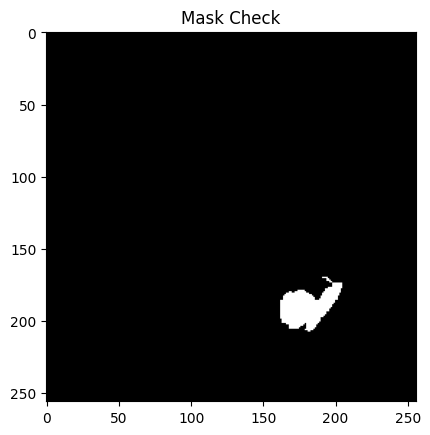

Unique values: [  0 255]


In [ ]:
mask_path = "/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_15_mask.tif"
mask = Image.open(mask_path)
mask_np = np.array(mask)
plt.imshow(mask_np, cmap='gray')
plt.title("Mask Check")
plt.show()
print("Unique values:", np.unique(mask_np))


In [ ]:
import cv2
from torch.utils.data import Dataset
import numpy as np

class BrainMRIDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Read image and mask
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        # Resize image and mask
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        mask = cv2.resize(mask, (128, 128), interpolation=cv2.INTER_NEAREST)

        # Check and binarize mask if needed
        if mask.max() > 1:
            mask = (mask > 0).astype(np.uint8)

        # Normalize image
        img = img / 255.0
        img = np.expand_dims(img, axis=0)  # Add channel dimension
        mask = np.expand_dims(mask, axis=0)

        return img.astype(np.float32), mask.astype(np.float32)


In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

def create_df(base_dir):
    images = []
    masks = []

    for folder in os.listdir(base_dir):
        full_path = os.path.join(base_dir, folder)
        if os.path.isdir(full_path):
            files = sorted(os.listdir(full_path))
            for file in files:
                if file.endswith('.tif') and '_mask' not in file:
                    img_path = os.path.join(full_path, file)
                    mask_path = img_path.replace(".tif", "_mask.tif")
                    if os.path.exists(mask_path):
                        images.append(img_path)
                        masks.append(mask_path)

    df = pd.DataFrame({'images_paths': images, 'masks_paths': masks})
    return df


def split_df(df, train_size=0.7, val_size=0.15, test_size=0.15):
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42)
    valid_df, test_df = train_test_split(temp_df, test_size=test_size / (val_size + test_size), random_state=42)
    return train_df, valid_df, test_df


In [ ]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128

class MRIImageGenerator(Sequence):
    def __init__(self, df, batch_size=16, aug_dict={}, shuffle=True):
        self.df = df.reset_index(drop=True)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(self.df))
        self.augmentor = ImageDataGenerator(**aug_dict)
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_imgs, batch_masks = [], []

        for i in batch_idx:
            img = cv2.imread(self.df.loc[i, 'images_paths'], cv2.IMREAD_GRAYSCALE)
            mask = cv2.imread(self.df.loc[i, 'masks_paths'], cv2.IMREAD_GRAYSCALE)

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
            mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE)) / 255.0
            mask = (mask > 0.5).astype(np.float32)

            img = np.expand_dims(img, axis=-1)
            mask = np.expand_dims(mask, axis=-1)

            # Apply augmentation (image + mask)
            if self.augmentor:
                seed = np.random.randint(0, 1e6)
                img = self.augmentor.random_transform(img, seed=seed)
                mask = self.augmentor.random_transform(mask, seed=seed)

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)

def create_gens(df, aug_dict):
    return MRIImageGenerator(df, batch_size=16, aug_dict=aug_dict)


In [ ]:
# Set path
data_dir = '/content/lgg-mri-segmentation/kaggle_3m'

# Create dataframe and split
df = create_df(data_dir)
train_df, valid_df, test_df = split_df(df)

# Define augmentation
tr_aug_dict = dict(rotation_range=0.2,
                   width_shift_range=0.05,
                   height_shift_range=0.05,
                   shear_range=0.05,
                   zoom_range=0.05,
                   horizontal_flip=True,
                   fill_mode='nearest')

# Create generators
train_gen = create_gens(train_df, aug_dict=tr_aug_dict)
valid_gen = create_gens(valid_df, aug_dict={})
test_gen = create_gens(test_df, aug_dict={})


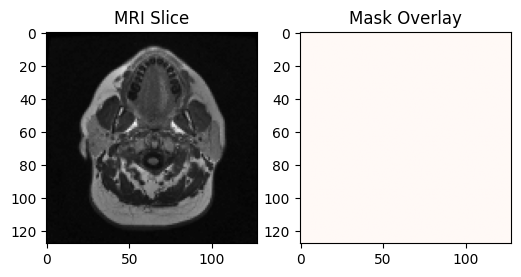

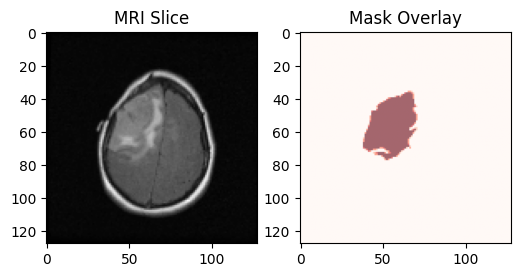

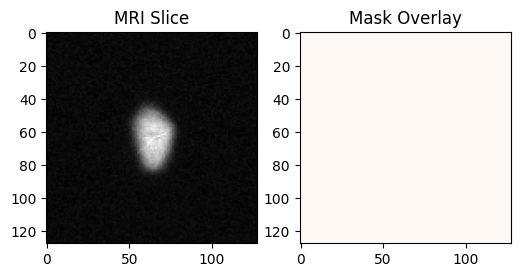

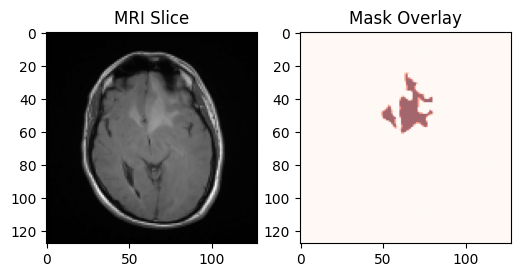

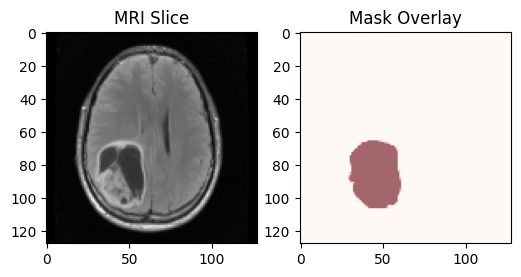

In [ ]:
import matplotlib.pyplot as plt

def show_images(img_paths, mask_paths, num=5):
    for i in range(num):
        img = cv2.imread(img_paths[i], cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        plt.figure(figsize=(6, 3))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title('MRI Slice')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='Reds', alpha=0.6)
        plt.title('Mask Overlay')
        plt.show()

show_images(list(train_df['images_paths']), list(train_df['masks_paths']))


In [ ]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2,2))(c1)

    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2,2))(c2)

    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = layers.UpSampling2D((2,2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2,2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(32, (3,3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2,2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, (1,1), activation='sigmoid')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 128, 128,  │        160 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_31 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_30[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64,    │          0 │ conv2d_31[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_6[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_32[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_7[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_34[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 16, 16,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_8[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_36[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 32, 32,    │          0 │ conv2d_37[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 32, 32,    │          0 │ up_sampling2d_6[… │
│ (Concatenate)       │ 192)              │            │ conv2d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 32, 32,    │    110,656 │ concatenate_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 64, 64,    │          0 │ conv2d_39[0][0] 

 Total params: 487,009 (1.86 MB)

 Trainable params: 487,009 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15
)


Epoch 1/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 25s 83ms/step - accuracy: 0.9585 - loss: 0.1532 - val_accuracy: 0.9900 - val_loss: 0.0376
Epoch 2/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9872 - loss: 0.0403 - val_accuracy: 0.9897 - val_loss: 0.0354
Epoch 3/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.9878 - loss: 0.0361 - val_accuracy: 0.9898 - val_loss: 0.0345
Epoch 4/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9874 - loss: 0.0366 - val_accuracy: 0.9898 - val_loss: 0.0339
Epoch 5/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9876 - loss: 0.0344 - val_accuracy: 0.9906 - val_loss: 0.0338
Epoch 6/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9882 - loss: 0.0335 - val_accuracy: 0.9914 - val_loss: 0.0289
Epoch 7/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9892 - loss: 0.0298 - val_accuracy: 0.9920 - val_loss: 0.0263
Epoch 8/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9899 - loss: 0.0274 - 

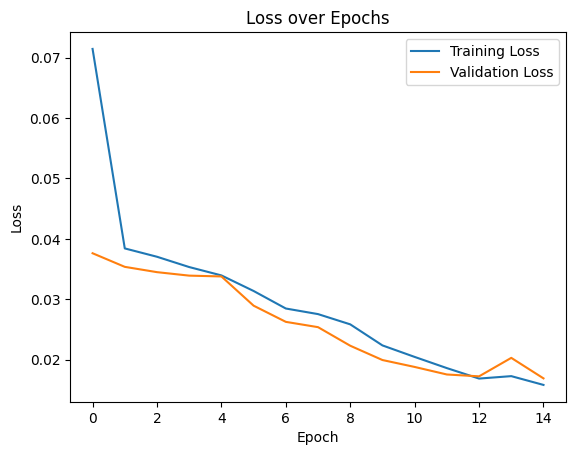

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9944 - loss: 0.0173
Test Loss: 0.0171, Test Accuracy: 0.9945


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step


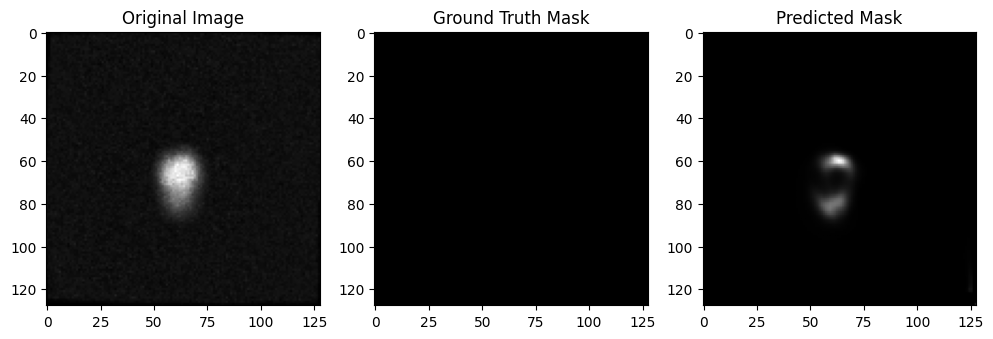

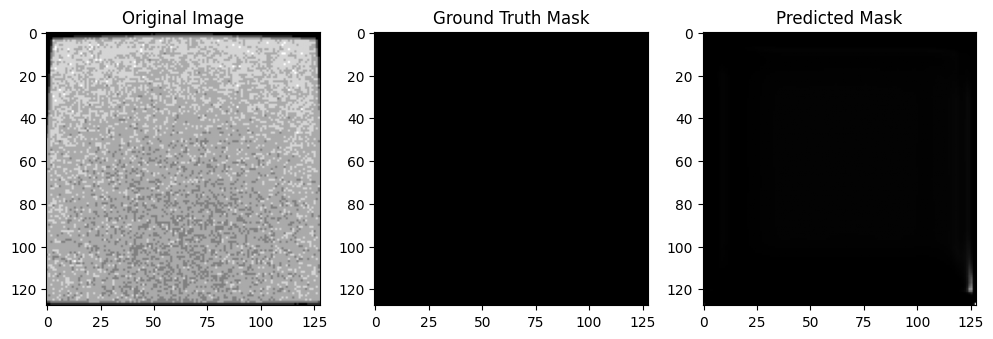

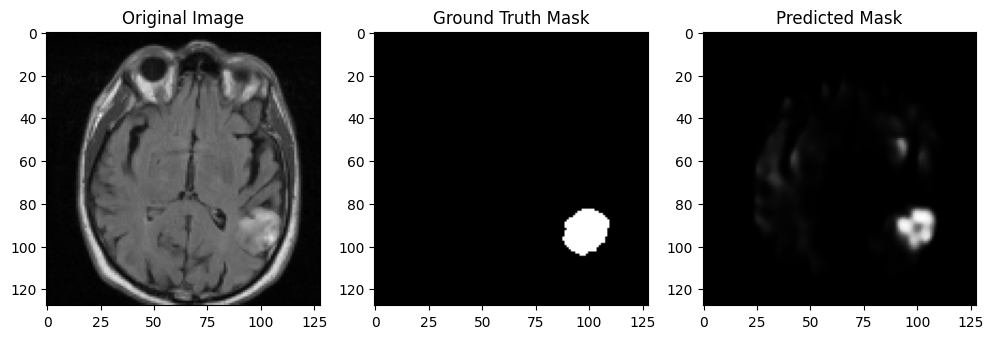

In [ ]:
def visualize_prediction(model, generator):
    images, masks = generator[0]
    preds = model.predict(images)

    for i in range(3):  # Show first 3 examples
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Original Image")

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.title("Predicted Mask")

        plt.show()

visualize_prediction(model, test_gen)


In [ ]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [ ]:
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=[dice_coefficient, 'accuracy'])

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=15
)


Epoch 1/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.9919 - dice_coefficient: 0.6562 - loss: 0.3438 - val_accuracy: 0.9950 - val_dice_coefficient: 0.6886 - val_loss: 0.3114
Epoch 2/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.9925 - dice_coefficient: 0.6715 - loss: 0.3285 - val_accuracy: 0.9943 - val_dice_coefficient: 0.6752 - val_loss: 0.3248
Epoch 3/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9932 - dice_coefficient: 0.7123 - loss: 0.2877 - val_accuracy: 0.9951 - val_dice_coefficient: 0.6916 - val_loss: 0.3084
Epoch 4/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.9931 - dice_coefficient: 0.7175 - loss: 0.2825 - val_accuracy: 0.9942 - val_dice_coefficient: 0.6709 - val_loss: 0.3291
Epoch 5/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9927 - dice_coefficient: 0.6932 - loss: 0.3068 - val_accuracy: 0.9949 - val_dice_coefficient: 0.7134 - val_loss: 0.2866
Epoch 6/15
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accu

In [ ]:
model.save("brain_mrid_unet.h5")  # Save model


In [ ]:
from tensorflow.keras.models import load_model

# Load model with custom loss and metric
model = load_model("brain_mrid_unet.h5",
                   custom_objects={'dice_loss': dice_loss, 'dice_coefficient': dice_coefficient})


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 674ms/step


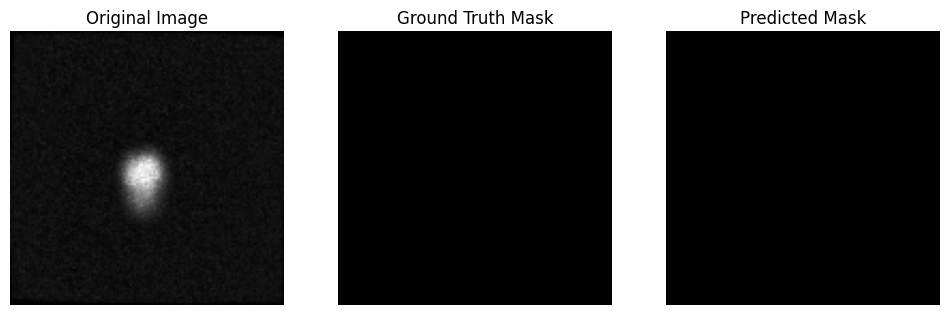

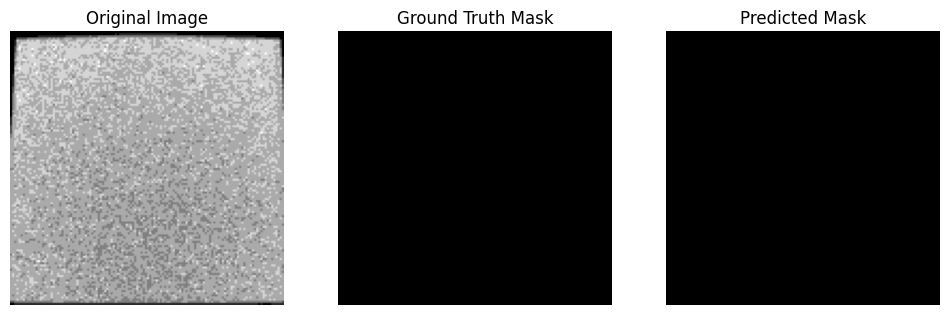

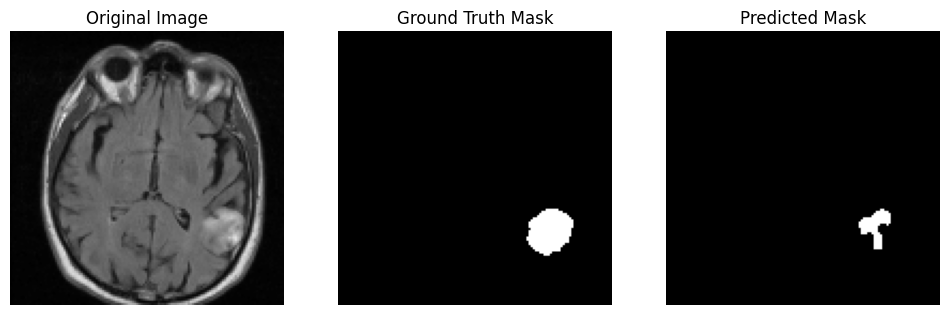

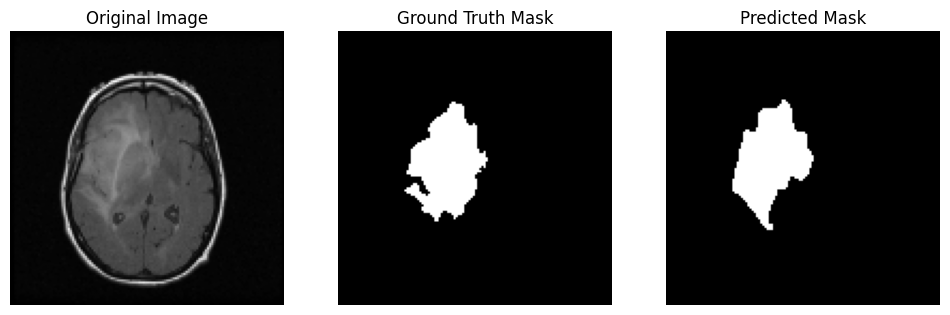

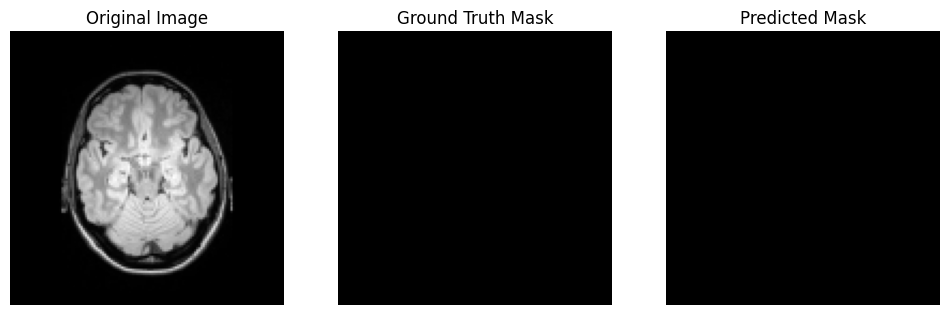

In [ ]:
def visualize_prediction(model, generator, num_samples=3):
    images, masks = generator[0]  # Get a batch from the generator
    preds = model.predict(images)

    for i in range(num_samples):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow((preds[i].squeeze() > 0.5), cmap='gray')  # Thresholded prediction
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

# Run the function
visualize_prediction(model, test_gen, num_samples=5)


In [ ]:
loss, dice, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Dice Coefficient: {dice:.4f}, Accuracy: {acc:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9962 - dice_coefficient: 0.8043 - loss: 0.1957
Test Loss: 0.2167, Dice Coefficient: 0.7833, Accuracy: 0.9958


In [ ]:
# Load classification model
classification_model = load_model("/content/brainCNN.h5")  # Replace with your filename

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = 128  # Should match both models' input size

def run_pipeline(image_path):
    # --- Step 1: Preprocess image for both models ---
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
    img_input = np.expand_dims(img_resized, axis=(0, -1))  # Shape: (1, 128, 128, 1)

    # --- Step 2: Classification prediction ---
    class_pred = classification_model.predict(img_input)[0]
    class_label = np.argmax(class_pred)
    confidence = np.max(class_pred)

    # --- Step 3: Segmentation prediction ---
    mask_pred = segmentation_model.predict(img_input)[0].squeeze()

    # --- Step 4: Display results ---
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original MRI")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_pred, cmap='Reds', alpha=0.6)
    plt.title("Predicted Tumor Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(img, cmap='gray')
    plt.imshow(mask_pred, cmap='Reds', alpha=0.5)
    plt.title(f"Class: {class_label} ({confidence:.2f})")

    plt.tight_layout()
    plt.show()


In [ ]:
image_path = "/content/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_15.tif"
run_pipeline(image_path)


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "conv2d" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (1, 128, 128, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(1, 128, 128, 1), dtype=float32)
  • training=False
  • mask=None